# Tennis

Exploration of point-by-point Wimbledon 2017 data, trying to build a predictive model of the best indicator of victory.

## Load data and libraries

In [1]:
%matplotlib inline
import pandas as pd
pd.set_option('chained_assignment',None)
pd.options.display.max_columns=None
from pandas import Series, DataFrame

import numpy as np
np.set_printoptions(precision=4)

import os, shutil, glob, time 
import random, math
from pprint import pprint
from importlib import reload

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

from collections import OrderedDict
from plot_colors import plot_colors as pcl
my_colors = OrderedDict(pcl)

In [18]:
plt.style.use(['notebook'])

In [3]:
df = pd.read_csv('wimbledon_points.csv')
print(len(df), 'total points')
print(len(df.columns), 'total stats')

45774 total points
65 total stats


## Basic exploration

In [65]:
df.head(10)

,match_id,ElapsedTime,SetNo,P1GamesWon,P2GamesWon,SetWinner,GameNo,GameWinner,PointNumber,PointWinner,PointServer,Speed_KMH,P1Score,P2Score,P1Momentum,P2Momentum,P1PointsWon,P2PointsWon,P1Ace,P2Ace,P1Winner,P2Winner,P1DoubleFault,P2DoubleFault,P1UnfErr,P2UnfErr,P1NetPoint,P2NetPoint,P1NetPointWon,P2NetPointWon,P1BreakPoint,P2BreakPoint,P1BreakPointWon,P2BreakPointWon,History,Speed_MPH,P1BreakPointMissed,P2BreakPointMissed,ServeIndicator,ServeNumber,WinnerType,WinnerShotType,P1DistanceRun,P2DistanceRun,RallyCount,ServeWidth,ServeDepth,ReturnDepth
0,2017-wimbledon-1101,0:00:00,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0.0,0,0,0.000,0.000,0,NaN,NaN,NaN
1,2017-wimbledon-1101,0:00:00,1,0,0,0,1,0,1,2,1,170,0,15,0,3,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,21410.0,106,0,0,1,1.0,0,F,15.970,18.562,6,W,NCTL,ND
2,2017-wimbledon-1101,0:00:31,1,0,0,0,1,0,2,1,1,170,15,15,3,3,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,11010.0,106,0,0,1,1.0,0,F,20.269,23.314,7,C,NCTL,ND
3,2017-wimbledon-1101,0:01:11,1,0,0,0,1,0,3,2,1,183,15,30,2,5,1,2,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,12030.0,114,0,0,1,1.0,0,0,40.908,41.750,16,BC,CTL,ND
4,2017-wimbledon-1101,0:02:02,1,0,0,0,1,0,4,2,1,0,15,40,1,6,1,3,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,15000.0,0,0,0,1,0.0,0,0,0.225,0.468,0,NaN,NaN,NaN
5,2017-wimbledon-1101,0:02:39,1,0,0,0,1,0,5,1,1,165,30,40,3,5,2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,21030.0,103,0,1,1,1.0,0,0,4.236,5.648,1,W,NCTL,D
6,2017-wimbledon-1101,0:03:03,1,0,0,0,1,0,6,1,1,178,40,40,5,4,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,21030.0,111,0,1,1,1.0,0,0,29.350,28.815,7,C,NCTL,ND
7,2017-wimbledon-1101,0:03:39,1,0,0,0,1,0,7,1,1,175,AD,40,7,3,4,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21030.0,109,0,0,1,1.0,0,0,5.187,5.724,1,W,CTL,D
8,2017-wimbledon-1101,0:04:01,1,1,0,0,1,1,8,1,1,185,0,0,11,2,5,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21032.0,115,0,0,2,1.0,0,0,5.245,4.851,1,C,CTL,D
9,2017-wimbledon-1101,0:04:48,1,1,0,0,2,0,9,2,2,214,0,15,10,4,5,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12030.0,133,0,0,2,1.0,0,0,5.081,5.751,1,C,NCTL,ND


### Missing stats

65 total player stats. How many of those are completely missing (all points filled with NaNs?)

In [4]:
missing_stats = df.columns[df.isnull().all()].tolist()
partial_stats = df.columns[df.isnull().any()].tolist()
full_stats = df.columns[~df.isnull().any()].tolist()

In [5]:
missing_stats
print(len(missing_stats), 'missing stats')
print(len(partial_stats), 'stats that are partially complete')
print(len(full_stats), 'stats that are complete')

17 missing stats
22 stats that are partially complete
43 stats that are complete


Drop those columns that are completely missing.

In [6]:
df = df.drop(columns=missing_stats)

### Helper functions

In [7]:
#return either player 1 or 2 for winner of last point and thus winner of match
def match_winner(MATCH_ID):
    if not any(df.match_id.str.contains(MATCH_ID)):
        raise ValueError('Match ID', MATCH_ID, 'not found')
    return df[df.match_id==MATCH_ID].PointWinner.iloc[-1]

#return match statistic (e.g player 1 aces, )
def match_stat(MATCH_ID, stat):
    if stat not in df.columns:
        raise ValueError('Statistic', stat, 'not found')
    if not any(df.match_id.str.contains(MATCH_ID)):
        raise ValueError('Match ID', MATCH_ID, 'not found')
    return df[df.match_id==match][stat].sum()

### Chance of winning and unforced errors 

Notice there is no direct information on the match winner in the data, but we can get it indirectly from the winner of 
the final point.

Of those who won, how many unforced errors did they have?

In [14]:
matches = df.match_id.unique()
winner_unforced_errors = np.zeros(len(matches))
for i, match in enumerate(matches):
    winner = match_winner(match)
    if winner == 1:
        winner_unforced_errors[i] = df[df.match_id==match]["P1UnfErr"].sum()
    else:
        winner_unforced_errors[i] = df[df.match_id==match]["P2UnfErr"].sum()

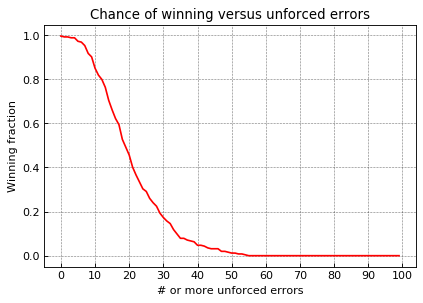

In [71]:
x, y = [], []
for i in range(100):
    fraction_of_winners = len(winner_unforced_errors[winner_unforced_errors > i])/len(winner_unforced_errors)
    x.append(i)
    y.append(fraction_of_winners)
    
plt.figure(figsize=(6,4),dpi=80)    
plt.xlabel("# or more unforced errors")
plt.ylabel("Winning fraction")
plt.xticks(np.arange(0,101,10))
plt.plot(x,y,color=my_colors['red'])
plt.title('Chance of winning versus unforced errors')
plt.grid(b=True, axis='both',linestyle=":",linewidth=0.5)
plt.show()

What else do we have apart from unforced errors?
 * Aces
 * 1st serve points won %
 * 2nd serve points won %
 * Winners
 * Double faults
 * Average serve speed
 * Total distance run 
 
Set-by-set: do these statistics go down/up as match goes on?

### Total aces and winners

In [75]:
matches = df.match_id.unique()
P1_stats = ["P1UnfErr","P1Ace","P1Winner","P1DoubleFault"]
P2_stats = ["P2UnfErr","P2Ace","P2Winner","P2DoubleFault"]

n_stats = len(P1_stats)
n_matches = len(matches)
winner_stats = np.zeros([n_stats,n_matches])
loser_stats = np.zeros([n_stats,n_matches])

        
for i, match in enumerate(matches):
    winner = match_winner(match)
    if winner == 1:
        for j, (winner_stat, loser_stat) in enumerate(zip(P1_stats, P2_stats)):
            winner_stats[j][i] = df[df.match_id==match][winner_stat].sum()
            loser_stats[j][i] = df[df.match_id==match][loser_stat].sum()
    else:
        for j, (winner_stat, loser_stat) in enumerate(zip(P2_stats, P1_stats)):
            winner_stats[j][i] = df[df.match_id==match][winner_stat].sum()
            loser_stats[j][i] = df[df.match_id==match][loser_stat].sum()

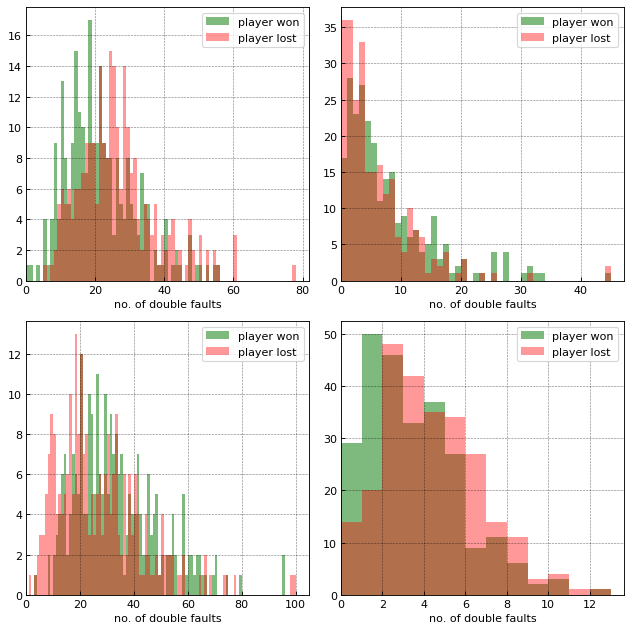

In [74]:
plt.figure(figsize=(8,8),dpi=80)
plot_labels = ['no. of unforced errors',
               'no. of aces',
               'no. of winners',
               'no. of double faults']

i=1
for (winner_stat, loser_stat, plot_label) in zip(winner_stats, loser_stats, plot_labels):
    
    plt.subplot(2,2,i)
    xmin, xmax = 0, int(max(max(winner_stat), max(loser_stat)))
    nbins = xmax + 1
    plt.hist(winner_stat,bins=np.linspace(xmin,xmax,nbins),alpha=0.6,label='player won',color=my_colors['forest-green'])
    plt.hist(loser_stat,bins=np.linspace(xmin,xmax,nbins),alpha=0.4,label='player lost',color=my_colors['red'])
    plt.xlim((0, None))
    plt.xlabel(label)
    plt.legend()
    plt.grid(b=True, axis='both',linestyle=":",linewidth=0.5)
    i+=1
plt.tight_layout()
plt.show()    

### Serve statistics

 * 1st and 2nd serve % won and speed
 * 1st serve in %
 * Width/depth: how much is missing, can we do anything with it?
 * Difference between serveindicator and serve number?


In [73]:
df[['P1Score', 'P2Score', 'PointServer', 'ServeIndicator', 'ServeNumber', 'PointWinner']].head()

,P1Score,P2Score,PointServer,ServeIndicator,ServeNumber,PointWinner
0,0,0,0,0,0.0,0
1,0,15,1,1,1.0,2
2,15,15,1,1,1.0,1
3,15,30,1,1,1.0,2
4,15,40,1,1,0.0,2


In [78]:
winner_first_serve_percentage, loser_first_serve_percentage = np.zeros(len(matches)), np.zeros(len(matches))
winner_second_serve_percentage, loser_second_serve_percentage = np.zeros(len(matches)), np.zeros(len(matches))
for i, match in enumerate(matches):
    winner = match_winner(match)
    
    p1_first_serve_pts_won = len(df[(df.PointServer==1) &
                                    (df.PointServer==df.PointWinner) &
                                    (df.ServeIndicator==1) & 
                                    (df.match_id==match)])
    p1_first_serve_pts = len(df[(df.PointServer==1) &
                                (df.ServeIndicator==1) & 
                                (df.match_id==match)])
    p2_first_serve_pts_won = len(df[(df.PointServer==2) &
                                    (df.PointServer==df.PointWinner) &
                                    (df.ServeIndicator==1) & 
                                    (df.match_id==match)])
    p2_first_serve_pts = len(df[(df.PointServer==2) &
                                (df.ServeIndicator==1) & 
                                (df.match_id==match)])
    
    
    p1_second_serve_pts_won = len(df[(df.PointServer==1) &
                                    (df.PointServer==df.PointWinner) &
                                    (df.ServeIndicator==2) & 
                                    (df.match_id==match)])
    p1_second_serve_pts = len(df[(df.PointServer==1) &
                                (df.ServeIndicator==2) & 
                                (df.match_id==match)])
    p2_second_serve_pts_won = len(df[(df.PointServer==2) &
                                    (df.PointServer==df.PointWinner) &
                                    (df.ServeIndicator==2) & 
                                    (df.match_id==match)])
    p2_second_serve_pts = len(df[(df.PointServer==2) &
                                (df.ServeIndicator==2) & 
                                (df.match_id==match)])
    
    if winner == 1:
        winner_first_serve_percentage[i] = p1_first_serve_pts_won/p1_first_serve_pts
        loser_first_serve_percentage[i] = p2_first_serve_pts_won/p2_first_serve_pts
        winner_second_serve_percentage[i] = p1_second_serve_pts_won/p1_second_serve_pts
        loser_second_serve_percentage[i] = p2_second_serve_pts_won/p2_second_serve_pts
    else:
        winner_first_serve_percentage[i] = p2_first_serve_pts_won/p2_first_serve_pts
        loser_first_serve_percentage[i] = p1_first_serve_pts_won/p1_first_serve_pts
        winner_second_serve_percentage[i] = p2_second_serve_pts_won/p2_second_serve_pts
        loser_second_serve_percentage[i] = p1_second_serve_pts_won/p1_second_serve_pts        


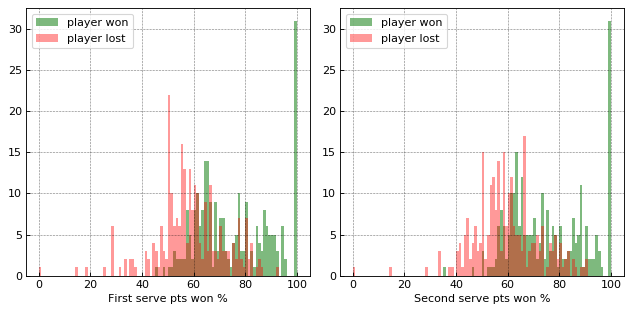

In [80]:
i=1
plt.figure(figsize=(8,4),dpi=80)
for [winner_stat, loser_stat, label] in [[winner_first_serve_percentage, loser_first_serve_percentage, 'First serve pts won %'],
                                         [winner_second_serve_percentage, loser_second_serve_percentage, 'Second serve pts won %']]:

    plt.subplot(1,2,i)
    xmin, xmax = 0, 100
    nbins = 101
    plt.hist(100*winner_stat,bins=np.linspace(xmin,xmax,nbins),alpha=0.6,label='player won',color=my_colors['forest-green'])
    plt.hist(100*loser_stat,bins=np.linspace(xmin,xmax,nbins),alpha=0.4,label='player lost',color=my_colors['red'])
    plt.xlabel(label)
    plt.legend()
    plt.grid(b=True, axis='both',linestyle=":",linewidth=0.5)
    i+=1
#plt.suptitle('First and second serve percentage won')
plt.tight_layout()
plt.show()  

Average serve speed.

In [81]:
df.columns

Index(['match_id', 'ElapsedTime', 'SetNo', 'P1GamesWon', 'P2GamesWon',
       'SetWinner', 'GameNo', 'GameWinner', 'PointNumber', 'PointWinner',
       'PointServer', 'Speed_KMH', 'P1Score', 'P2Score', 'P1Momentum',
       'P2Momentum', 'P1PointsWon', 'P2PointsWon', 'P1Ace', 'P2Ace',
       'P1Winner', 'P2Winner', 'P1DoubleFault', 'P2DoubleFault', 'P1UnfErr',
       'P2UnfErr', 'P1NetPoint', 'P2NetPoint', 'P1NetPointWon',
       'P2NetPointWon', 'P1BreakPoint', 'P2BreakPoint', 'P1BreakPointWon',
       'P2BreakPointWon', 'History', 'Speed_MPH', 'P1BreakPointMissed',
       'P2BreakPointMissed', 'ServeIndicator', 'ServeNumber', 'WinnerType',
       'WinnerShotType', 'P1DistanceRun', 'P2DistanceRun', 'RallyCount',
       'ServeWidth', 'ServeDepth', 'ReturnDepth'],
      dtype='object')

### Length of rallies

How to plot this? Do winners tend to have shorter length

### TODO

 * Arrange features into `df_matches` dataframe with unique `match+player_id` key

## Baseline model

## Set-by-set

## Historical trends

## Comparison of surfaces

## Build model